## Scratch

In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data
from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
# shape_net_category_to_synth_id()

{'airplane': '02691156',
 'bag': '02773838',
 'basket': '02801938',
 'bathtub': '02808440',
 'bed': '02818832',
 'bench': '02828884',
 'bicycle': '02834778',
 'birdhouse': '02843684',
 'bookshelf': '02871439',
 'bottle': '02876657',
 'bowl': '02880940',
 'bus': '02924116',
 'cabinet': '02933112',
 'camera': '02942699',
 'can': '02747177',
 'cap': '02954340',
 'car': '02958343',
 'chair': '03001627',
 'clock': '03046257',
 'dishwasher': '03207941',
 'display': '03211117',
 'earphone': '03261776',
 'faucet': '03325088',
 'file': '03337140',
 'guitar': '03467517',
 'helmet': '03513137',
 'jar': '03593526',
 'keyboard': '03085013',
 'knife': '03624134',
 'lamp': '03636649',
 'laptop': '03642806',
 'mailbox': '03710193',
 'microphone': '03759954',
 'microwave': '03761084',
 'motorcycle': '03790512',
 'mug': '03797390',
 'piano': '03928116',
 'pillow': '03938244',
 'pistol': '03948459',
 'pot': '03991062',
 'printer': '04004475',
 'remote_control': '04074963',
 'rifle': '04090263',
 'rocket'

In [41]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
syn_id = '02834778'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/2048/' + syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=20)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

59 files containing complete point clouds were found.


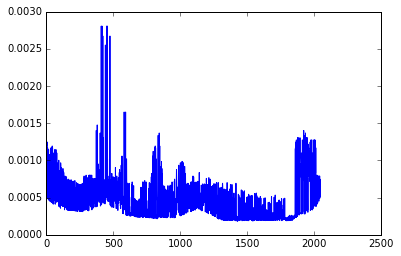

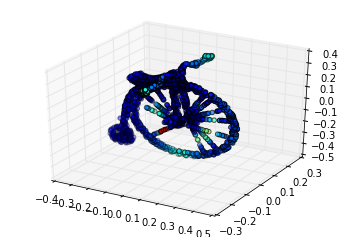

In [49]:
from sklearn.neighbors import NearestNeighbors

points = full_pclouds[4]

def density_weights(points, radius):
    nn = NearestNeighbors().fit(points)
    indices = nn.radius_neighbors(radius=radius, return_distance=False)
    density = np.array([i.size for i in indices], dtype=np.float128)
    return density

def inverse_normalize_weights(weights):
    w = weights
    inv_w = 1.0 / w[w != 0]
    w[w != 0] = inv_w
    w /= np.sum(w)
    return w.astype(np.float32)

w = inverse_normalize_weights(density_weights(points, radius = 0.1))

plt.plot(w)

Point_Cloud(points=points).plot(c=w);


In [ ]:
'''Least squares normal estimation from point clouds using PCA
 H. Hoppe, T. DeRose, T. Duchamp, J. McDonald, and W. Stuetzle. 
 Surface reconstruction from unorganized points. 
 In Proceedings of ACM Siggraph, pages 71:78, 1992.

 p should be a matrix containing the horizontally concatenated column
 vectors with points. k is a scalar indicating how many neighbors the
 normal estimation is based upon. '''

def lsq_normal_estimation(pcloud, k=100)
m = size(p,2);
n = zeros(3,m);

v = ver('stats');
if str2double(v.Version) >= 7.5 
    neighbors = transpose(knnsearch(transpose(p), transpose(p), 'k', k+1));
else
    neighbors = k_nearest_neighbors(p, p, k+1);
end

for i = 1:m
    x = p(:,neighbors(2:end, i));
    p_bar = 1/k * sum(x,2);
    
    P = (x - repmat(p_bar,1,k)) * transpose(x - repmat(p_bar,1,k)); %spd matrix P
    %P = 2*cov(x);
    
    [V,D] = eig(P);
    
    [~, idx] = min(diag(D)); % choses the smallest eigenvalue
    
    n(:,i) = V(:,idx);   % returns the corresponding eigenvector    
end


In [173]:
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/2048/' + syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds_2, full_model_names_2, full_syn_ids_2 = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=20)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


In [122]:
full_pclouds_path = '/orions4-zfs/projects/lins2/Panos_Space/DATA/ShapeNetPointClouds/from_original_meshes/3000/no_segmentations/' + syn_id
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds_3, full_model_names_3, full_syn_ids_3 = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=20)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

7497 files containing complete point clouds were found.


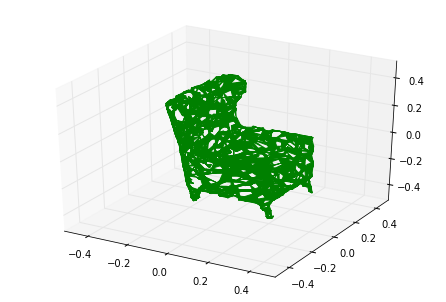

In [198]:
# shape_net_category_to_synth_id()
src = 100


trg = np.where(full_model_names[src] == full_model_names_2)[0][0]
# Point_Cloud(points= full_pclouds[src]).plot();
# Point_Cloud(points= full_pclouds_2[trg]).plot();

pts = full_pclouds_2[trg]

from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=6).fit(pts)
distances, indices = nn.kneighbors(pts)

# indices[:,1:].shape

tr = np.vstack((indices[:,0:3], indices[:,3:6]))
m = Mesh(vertices=pts, triangles=tr)
m.center_in_unit_sphere()

plot_mesh_2(m, in_u_sphere=True)

print 




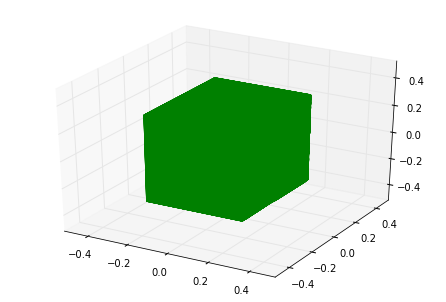

In [145]:
mesh_file = '/orions4-zfs/projects/lins2/Panos_Space/DATA/ShapeNetManifold/20000/04330267/177fedf455e50b4d352845ab138522d8//model.obj'
from geo_tool import Mesh
from tf_lab.autopredictors.exploration import plot_mesh_2

in_m = Mesh(file_name=mesh_file)
in_m.swap_axes_of_vertices([0,2,1])
in_m.center_in_unit_sphere()

plot_mesh_2(in_m, in_u_sphere=True)

In [149]:
in_m.triangles.shape

(78556, 3)

In [82]:
train_data_, val_data_, test_data_ = pio.train_validate_test_split([full_pclouds,                                                             
                                                            full_model_names],
                                                            train_perc=0.8,
                                                            validate_perc=0.1,
                                                            test_perc=0.1,
                                                            seed=seed)



test_data = merge_val_test_data(val_data_, test_data_)

10421

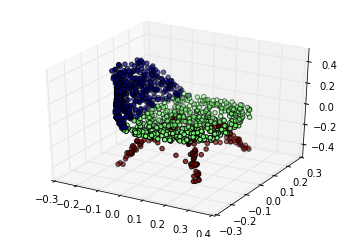

Point Cloud with 1024 points.


In [67]:

DATA_PATH = '/orions4-zfs/projects/lins2/Panos_Space/DATA/SN_with_part_annotation/03001627/expert_verified/points_label/'
model_id = '1015e71a0d21b127de03ab2a27ba7531.seg'
seg_file = osp.join(DATA_PATH, model_id)


DATA_PATH = '/orions4-zfs/projects/lins2/Panos_Space/DATA/SN_with_part_annotation/03001627/points/'
model_id = '1015e71a0d21b127de03ab2a27ba7531.pts'
pts_file = osp.join(DATA_PATH, model_id)





# bool_mask = np.logical_or(c==1, c==2)
# def apply_mask(self, bool_mask):
#     return Point_Cloud(self.points[bool_mask, :])
# apply_mask(pc, bool_mask).plot()

array([[ 0.26109004,  0.09401268, -0.02499332]], dtype=float32)

array([[-0.0246922 ,  0.10568816, -0.11596782]], dtype=float32)

array([False,  True,  True, ...,  True,  True, False], dtype=bool)

In [5]:
file_names = pio.load_filenames_of_input_data(DATA_PATH, verbose=VERBOSE)

all_pclouds, model_names, class_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=15, verbose=VERBOSE)

train_data_, val_data_, test_data_ = pio.train_validate_test_split(
                                                           [all_pclouds,                                                             
                                                            model_names],
                                                            train_perc=0.8,
                                                            validate_perc=0.1,
                                                            test_perc=0.1,
                                                            seed=seed)

trs = set(train_data_[1])
vas = set(val_data_[1])
tes = set(test_data_[1])

assert trs.isdisjoint(vas) and vas.isdisjoint(tes) and tes.isdisjoint(trs)

52103 files were found.
52103 pclouds were loaded. They belong in 50 shape-classes.


/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/tf_lab/point_clouds/in_out.py:64: UserWarning: Point clouds with the same model name were loaded.
  warnings.warn('Point clouds with the same model name were loaded.')


AssertionError: 

In [9]:
train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
val_data = PointCloudDataSet(val_data_[0], labels=val_data_[1])
test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

In [37]:
# Experimenting with Tensorboard - Visualizations
from tf_lab.fundamentals.inspect import hist_summary_of_trainable
writer = tf.summary.FileWriter('/Users/optas/Desktop/test', ae.graph)
# hist_summary_of_trainable(ae.graph)

In [ ]:
# If you 'merge' Erics pclouds with his segmentations then use.
def read_pcloud_with_segs(in_file):
    in_data = np.loadtxt(in_file)
    pts = in_data[:, [0, 1, 2]]
    seg = in_data[:, 3].astype(np.int32)
    return pts, seg